# Hot Word Detection (data processing)

Hot word detection is about letting a virtual voice assistant recognize a word for waking up or to execute a certain action, like “Hey Siri” or “Hey Alexa”. The dataset and some methods for this project came from CS230 at Stanford by Andrew Ng.

### Requirements 
- numpy
- h5py
- pydub
- matplotlib
- scipy
- keras

In [0]:
!pip install pydub

## Process Data

In [0]:
!unzip raw_data.zip # local zip included in the repo
root = "./raw_data/"

from scipy.io import wavfile
from pydub import AudioSegment
import matplotlib.pyplot as plt
import os
import IPython
import numpy as np
import random
import sys
import io
import glob
%matplotlib inline

Archive:  raw_input.zip
   creating: raw_input/
   creating: raw_input/background/
  inflating: raw_input/background/1.wav  
   creating: __MACOSX/
   creating: __MACOSX/raw_input/
   creating: __MACOSX/raw_input/background/
  inflating: __MACOSX/raw_input/background/._1.wav  
  inflating: raw_input/background/2.wav  
  inflating: __MACOSX/raw_input/background/._2.wav  
  inflating: __MACOSX/raw_input/._background  
   creating: raw_input/positive/
  inflating: raw_input/positive/1_act3.wav  
   creating: __MACOSX/raw_input/positive/
  inflating: __MACOSX/raw_input/positive/._1_act3.wav  
  inflating: raw_input/positive/1_act2.wav  
  inflating: __MACOSX/raw_input/positive/._1_act2.wav  
  inflating: raw_input/positive/3_act3.wav  
  inflating: __MACOSX/raw_input/positive/._3_act3.wav  
  inflating: raw_input/positive/2_act3.wav  
  inflating: __MACOSX/raw_input/positive/._2_act3.wav  
  inflating: raw_input/positive/1.wav  
  inflating: __MACOSX/raw_input/positive/._1.wav  
  inflatin

#### Showcase data

The positive (containing "activate"), negative, and background audio files are separated, allowing us to synthesize more combination of data.

In [0]:
IPython.display.Audio(os.path.join(root, "positive/1.wav"))

In [0]:
IPython.display.Audio(os.path.join(root, "negative/1.wav"))

In [0]:
IPython.display.Audio(os.path.join(root, "background/1.wav"))

In [0]:
# get the audio hz
rate, audio_data = wavfile.read(os.path.join(root, "background/1.wav"))
print(f"Sample rate: {rate}")
print(f"Time steps: {len(audio_data[:,0])}")

Sample rate: 44100
Time steps: 441000


#### Convert audio to spectrogram

In [0]:
def graph_spectrogram(wav_file):
    """
    Plot and calculate spectrogram for audio (.wav)
    """
    rate, audio_data = wavfile.read(wav_file) # load wavfile
    n_fft = 200 # window length (length of fast fourier transform)
    sf = 8000 # number of samples per time (sample frequency)
    n_overlap = 120 # overlap length of windows
    n_channels = audio_data.ndim # number of dimensions
    if n_channels == 1:
        pxx, freqs, bins, im = plt.specgram(audio_data, n_fft, sf, noverlap = n_overlap)
    elif n_channels == 2: # multi-channel audio
        pxx, freqs, bins, im = plt.specgram(audio_data[:,0], n_fft, sf, noverlap = n_overlap)
    return pxx

Number of frequencies of spectrogram: 101
Number of timesteps of spectrogram: 5511


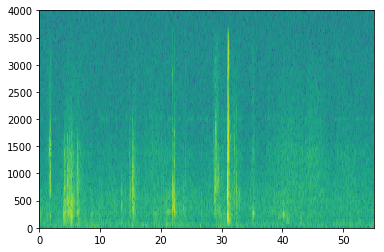

In [0]:
specgram = graph_spectrogram(os.path.join(root, "background/1.wav"))

print(f"Number of frequencies of spectrogram: {specgram.shape[0]}")
print(f"Number of timesteps of spectrogram: {specgram.shape[1]}")

#### Define parameters for 10 second audio 

In [0]:
T_x = 5511 # input time steps
T_y = 1375 # output time steps of model
n_freq = 101 # number of discrete audio frequencies

#### Get data with pydub

In [0]:
def load_raw_audio(root):
    """
    Load raw audio file for audio synthesis
    """
    positives = []
    negatives = []
    backgrounds = []
    
    for filename in os.listdir(os.path.join(root, "positive")):
        if filename.endswith("wav"):
            path = os.path.join(root, "positive", filename)
            positives.append(AudioSegment.from_wav(path))
            
    for filename in os.listdir(os.path.join(root, "negative")):
        if filename.endswith("wav"):
            path = os.path.join(root, "negative", filename)
            negatives.append(AudioSegment.from_wav(path))
            
    for filename in os.listdir(os.path.join(root, "background")):
        if filename.endswith("wav"):
            path = os.path.join(root, "background", filename)
            backgrounds.append(AudioSegment.from_wav(path))
    
    return positives, negatives, backgrounds

In [0]:
positives, negatives, backgrounds = load_raw_audio(root)
print("Average positive length: ", sum([len(x)/1000 for x in positives])/len(positives), "s")
print("Average negative length: ", sum([len(x)/1000 for x in negatives])/len(negatives), "s")
print("Background length: ", len(backgrounds[0])/1000, "s")
# as shown in the input, "activate" is quite a long word

Average positive length:  1.1037 s
Average negative length:  0.5744 s
Background length:  10.0 s


#### Perform audio synthesis

This is a relatively difficult part of the project involving randomly overlaying positive/negative audios on backgrounds without overlap and labelling the data at the same time.

In [0]:
def get_random_segment(duration, length=1e4):
    """
    Gets a randomtime segment in audio clip (default length = 10s * 1000ms/s)
    """
    start = np.random.randint(low=0, high=length-duration)
    end = start + duration - 1 # a careful "-1" for edge case
    return (start, end)

In [0]:
def is_overlapping(new_seg, segs):
    """
    Checks if new segment overlaps with existing ones
    """
    overlap = False
    start, end = new_seg
    for ex_start, ex_end in segs:
        if start <= ex_end and end >= ex_start:
            overlap = True
    return overlap

In [0]:
def insert_clip(background, clip, segs):
    """
    Insert new audio clip in background while avoiding overlaps
    """
    duration = len(clip)
    new_seg = get_random_segment(duration)
    while is_overlapping(new_seg, segs): # poke around until finding space
        new_seg = get_random_segment(duration)
    
    segs.append(new_seg) # update existing segs
    background = background.overlay(clip, position=new_seg[0]) # overlay
    return background, new_seg

In [0]:
def update_label(y, seg_end, length=1e4):
    """
    Update label y with 1s at 50 output steps after each positive segment 
    y is a vector with shape (1, T_y)
    """
    seg_end_output = int(seg_end*(T_y/length)) # convert I/O time scale
    for end in range(seg_end_output+1, seg_end_output+51):
        if end < T_y: # ensure stop at end of audio
            y[0, end] = 1.0
    return y

In [0]:
def standardize_volume(sound, target):
    """
    Standardize volume of audio clip (decibel relative to full scale)
    """
    delta = target - sound.dBFS # difference between dB FS
    return sound.apply_gain(delta)

In [0]:
def create_train_data(background, positives, negatives):
    background -= 20 # arbitrarily dimming the background noise
    y = np.zeros((1, T_y))
    segs = []
    
    # get positives
    n_p = np.random.randint(0, 5)
    n_p_indices = np.random.randint(len(positives), size=n_p)
    n_positives = [positives[idx] for idx in n_p_indices]
    
    # insert and update label
    for positive in n_positives:
        background, new_seg = insert_clip(background, positive, segs)
        start, end = new_seg
        y = update_label(y, end)
    
    # get negatives
    n_n = np.random.randint(0, 3)
    n_n_indices = np.random.randint(len(negatives), size=n_n)
    n_negatives = [negatives[idx] for idx in n_n_indices]
    
    # insert and update label
    for negative in n_negatives:
        background, _ = insert_clip(background, negative, segs)
    
    # standardize volume
    background = standardize_volume(background, -20.0)
    
    # save file
    _ = background.export("train.wav", format="wav")
    
    # spectrogram
    x = graph_spectrogram("train.wav")
    
    return x, y

#### Test audio synthesis functions

Rerun below cells to test the code.

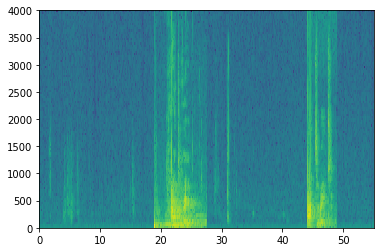

In [0]:
x, y = create_train_data(backgrounds[0], positives, negatives)

In [0]:
IPython.display.Audio("train.wav")

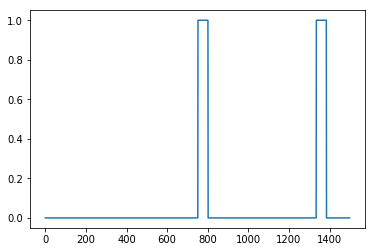

In [0]:
plt.plot(y[0])